In [1]:
import torch
import torch.nn.functional as Func
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


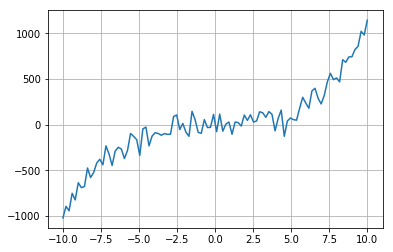

In [2]:
X = np.expand_dims(np.linspace(-10, 10, num=100, dtype=np.float32), -1)
x = torch.from_numpy(X)
noise = x.new_tensor(np.ones(x.size())).normal_(mean = 10, std = 80)
y =  x**3 + noise
plt.plot(x.data.numpy(), y.data.numpy())
plt.grid()

In [3]:
class GaussianRegressorNLL(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, sizes, min_var = 1e-6):
        super(GaussianRegressorNLL, self).__init__()
        self.h = torch.zeros(n_input,sizes)
        self.hidden = torch.nn.Linear(n_input,n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.sizes = sizes
        self.layers = [self.hidden for i in range(sizes)]
        self.num_layers = sizes
    def forward(self,x):
        h = x
        output = []
        for i in range(self.num_layers):
            out = Func.relu(self.hidden(x))
            out = self.predict(out)
            output.append(out)
        mean, raw_var  = output
        mean = torch.sign(x)*mean
        var = Func.softplus(raw_var) + 1e-6
        return mean.view(-1,1), var.view(-1,1)

In [4]:
## Gaussian Loss Function
class GaussianNLL(torch.nn.Module):
    def __init__(self):
        super(GaussianNLL,self).__init__()
    def forward(self, mean_values, var_values, y):
        error = torch.sub(y, mean_values)
        loss =  0.5 *(torch.mean(torch.log(var_values)) + torch.mean(torch.div(torch.mul(error,error),var_values))+ torch.log(2*torch.tensor(np.pi)))
        return loss

In [5]:
def mean_var_ensemble(ensemble, x):
    en_mean = 0
    en_var = 0
    for i,model in enumerate(ensemble):
        mean,var = model(Variable(x.view(1,-1)))
        en_mean += mean
        en_var += var + mean ** 2
    en_mean /= len(ensemble)
    en_var /= len(ensemble)
    en_var -= en_mean ** 2
    return en_mean.data.numpy(), en_var.data.numpy()

## Comparing Uncertainty using MSELoss and NLLLoss

In [6]:
model_nll = GaussianRegressorNLL(x.size()[0], 100, y.size()[0], sizes = 2)
model_mse = GaussianRegressorNLL(x.size()[0], 100, y.size()[0], sizes = 2)

In [7]:
learning = {'mse': 0.00001,
             'nll': 0.1}
loss_dict = {'mse': torch.nn.MSELoss(),
             'nll': GaussianNLL()}

## Hyper-parameters
alpha = 0.3
clipping = 0.25
num_iter = 50000
eps = 1e-2

In [8]:
learning_rate_mse = learning['mse']
loss_mse = loss_dict['mse']
optimizer_mse = optim.Adam(model_mse.parameters(),learning_rate_mse)
loss_mse, learning_rate_mse

(MSELoss(), 1e-05)

In [9]:
learning_rate_nll = learning['nll']
loss_nll = loss_dict['nll']
optimizer_nll = optim.Adam(model_nll.parameters(),learning_rate_nll)
loss_nll, learning_rate_nll

(GaussianNLL(), 0.1)

Iter: 0, Loss MSE: 168641.875
Iter: 0, Loss NLL: 280446.46875


/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()
/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


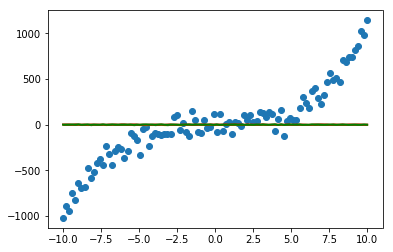

Iter: 10000, Loss MSE: 74479.7109375
Iter: 10000, Loss NLL: 58.96256637573242


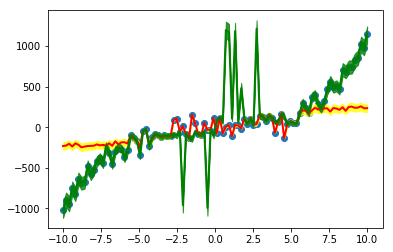

Iter: 20000, Loss MSE: 5581.94140625
Iter: 20000, Loss NLL: 24.310060501098633


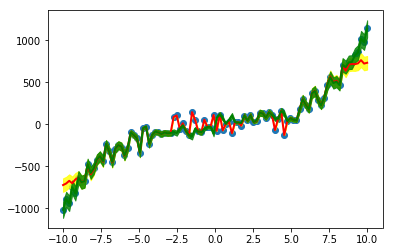

Iter: 30000, Loss MSE: 0.10768675804138184
Iter: 30000, Loss NLL: 24.245800018310547


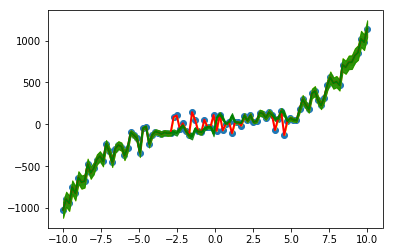

Iter: 40000, Loss MSE: 5.77121738842834e-07
Iter: 40000, Loss NLL: 289.35528564453125


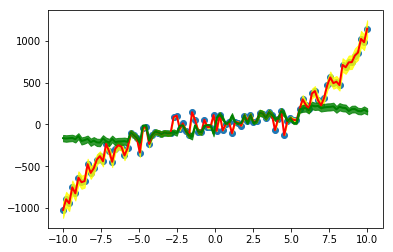

In [10]:
for i in range(num_iter):
    ## updating MSE preds
    preds_mse, var_mse = model_mse(Variable(x.view(1,-1)))
    lo_mse = loss_mse(preds_mse, y)
    (alpha * lo_mse).backward()
    optimizer_mse.step()
    optimizer_mse.zero_grad()
    
    ## updating NLL preds
    preds_nll, var_nll = model_nll(Variable(x.view(1,-1)))
    lo_nll = loss_nll(preds_nll, var_nll, y)
    (alpha * lo_nll).backward()
    optimizer_nll.step()
    optimizer_nll.zero_grad()
        
    torch.nn.utils.clip_grad_norm(model_mse.parameters(), clipping)
    torch.nn.utils.clip_grad_norm(model_nll.parameters(), clipping)
    
    if i %10000 ==0:
        print("Iter: {}, Loss MSE: {}".format(i, lo_mse.data.numpy()))
        print("Iter: {}, Loss NLL: {}".format(i, lo_nll.data.numpy()))
        
        std_mse = np.sqrt(var_mse.data.numpy())
        upper_mse = preds_mse.data.numpy() + 3 * std_mse
        lower_mse = preds_mse.data.numpy() - 3 * std_mse
        
        std_nll = np.sqrt(var_nll.data.numpy())
        upper_nll = preds_nll.data.numpy() + 3 * std_nll
        lower_nll = preds_nll.data.numpy() - 3 * std_nll
        
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), preds_mse.view(-1,1).data.numpy(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_mse.squeeze(), upper_mse.squeeze(), color='yellow', alpha=0.8)
        
        plt.plot(x.data.numpy(), preds_nll.view(-1,1).data.numpy(), 'g-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_nll.squeeze(), upper_nll.squeeze(), color='green', alpha=0.8)
        
        plt.pause(0.1)
plt.ioff()
plt.show()

In [11]:
## Testing the a single instance prediction

In [12]:
x_scale = np.linspace(-10,10,100)
x_scale[0:10]

array([-10.        ,  -9.7979798 ,  -9.5959596 ,  -9.39393939,
        -9.19191919,  -8.98989899,  -8.78787879,  -8.58585859,
        -8.38383838,  -8.18181818])

In [13]:
item_index = np.where(x == -8.18181818)
item_index

(array([9]), array([0]))

In [14]:
lo_nll.data

tensor(36.4517)

In [15]:
print(preds_nll[9], var_nll[9])

tensor([-570.4418]) tensor([ 570.4418])


##  NLL - Ensemble

In [16]:
alpha = 0.1
clipping = 0.25
max_iter = 5000
K = 10  # ensemble size
eps = 1e-2

learning = {'mse': 0.00001,
             'nll': 0.1}
loss_dict = {'mse': torch.nn.MSELoss(),
             'nll': GaussianNLL()}

define_loss = 'nll'
ensemble = [GaussianRegressorNLL(x.size()[0], 100, y.size()[0],2) for i in range(K)]
learning_rate = learning[define_loss]
loss_function = loss_dict[define_loss]
optimizer = [optim.Adam(ensemble[i].parameters(),learning_rate) for i in range(K)]
losses =[loss_function for i in range(K)]

In [17]:
loss_function, learning_rate

(GaussianNLL(), 0.1)

Iter: 0, Loss: 148555.171875


/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  # Remove the CWD from sys.path while we load stuff.


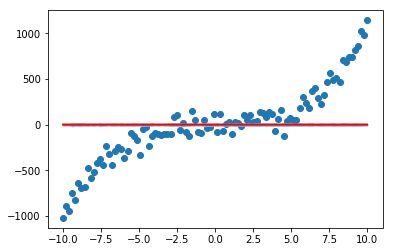

Iter: 1000, Loss: 49.53496551513672


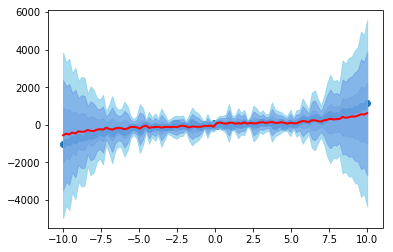

Iter: 2000, Loss: 37.791751861572266


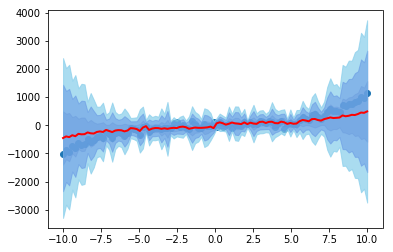

Iter: 3000, Loss: 82.18999481201172


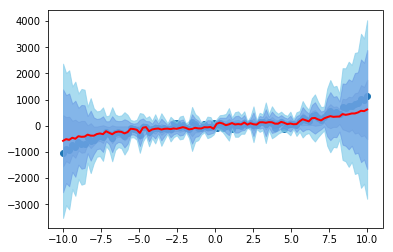

Iter: 4000, Loss: 42.653160095214844


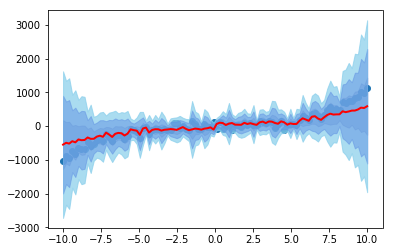

In [18]:
for i in range(max_iter):
    for model, opt, loss in zip(ensemble, optimizer, losses):
        inp = x.view(1,-1)
        preds, var = model(Variable(inp, requires_grad=True))
        if define_loss == 'nll':
            loss = loss_function(preds, var, y)
            opt.step()
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(model.parameters(), clipping)
    
        elif define_loss == 'mse':
            loss = loss_function(preds, y)
            opt.step()
            opt.zero_grad()
            loss.backward()
            
    if i %1000 ==0:
        print("Iter: {}, Loss: {}".format(i, loss.data.numpy()))
        mean_en, var_en = mean_var_ensemble(ensemble, x)
        std = np.sqrt(var_en)
        upper_3 = mean_en + 3 * std
        lower_3 = mean_en - 3 * std
        upper_6 = mean_en + 6 * std
        lower_6 = mean_en - 6 * std
        upper_9 = mean_en + 9 * std
        lower_9 = mean_en - 9 * std
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy().squeeze(), mean_en.squeeze(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_3.squeeze(), upper_3.squeeze(), color='darkblue', alpha=0.3)
        plt.fill_between(x.data.numpy().squeeze(), lower_6.squeeze(), upper_6.squeeze(), color='mediumblue', alpha=0.5)
        plt.fill_between(x.data.numpy().squeeze(), lower_9.squeeze(), upper_9.squeeze(), color='skyblue', alpha=0.7)

        plt.pause(0.1)
plt.ioff()
plt.show()

In [19]:
var_en[0][0]

58307.375

In [27]:
points = [0, 15, 49,50,41, 99]
max_val = np.max(var_en)
for point in points:
    #print(var_en[point][0])
    uncertainty = (1-var_en[point][0]/max_val)*100
    print("Mean value: {:.2f} +/- {:.2f}\nUncertainty: {:.2f}%".format(mean_en[point][0],var_en[point][0], uncertainty))
    print("-"*40)

Mean value: -597.51 +/- 56138.94
Uncertainty: 99.56%
----------------------------------------
Mean value: -310.96 +/- 520.92
Uncertainty: 100.00%
----------------------------------------
Mean value: -1304.11 +/- 6123160.50
Uncertainty: 51.89%
----------------------------------------
Mean value: 1557.79 +/- 9251662.00
Uncertainty: 27.31%
----------------------------------------
Mean value: -1493.56 +/- 7463162.00
Uncertainty: 41.36%
----------------------------------------
Mean value: 606.48 +/- 75973.22
Uncertainty: 99.40%
----------------------------------------


## Testing the model

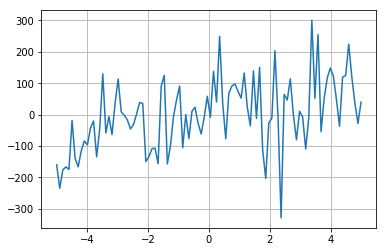

In [28]:
X = np.expand_dims(np.linspace(-5, 5, num=100, dtype=np.float32), -1)
x_test = torch.from_numpy(X)
noise = x.new_tensor(np.ones(x_test.size())).normal_(mean = 10, std = 100)
y_test =  x_test**3 + noise
plt.plot(x_test.data.numpy(), y_test.data.numpy())
plt.grid()

In [29]:
mean_test, var_test = mean_var_ensemble(ensemble, x_test)

In [30]:
std = np.sqrt(var_test)
upper_3 = mean_test + 3 * std
lower_3 = mean_test - 3 * std
upper_6 = mean_test + 6 * std
lower_6 = mean_test - 6 * std
upper_9 = mean_test + 9 * std
lower_9 = mean_test - 9 * std

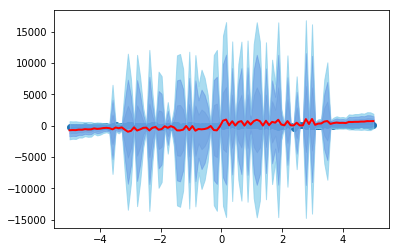

In [31]:
plt.scatter(x_test.data.numpy(), y_test.data.numpy())
plt.plot(x_test.data.numpy().squeeze(), mean_test.squeeze(), 'r-', lw=2)
plt.fill_between(x_test.data.numpy().squeeze(), lower_3.squeeze(), upper_3.squeeze(), color='darkblue', alpha=0.3)
plt.fill_between(x_test.data.numpy().squeeze(), lower_6.squeeze(), upper_6.squeeze(), color='mediumblue', alpha=0.5)
plt.fill_between(x_test.data.numpy().squeeze(), lower_9.squeeze(), upper_9.squeeze(), color='skyblue', alpha=0.7)

## Including adversarial training

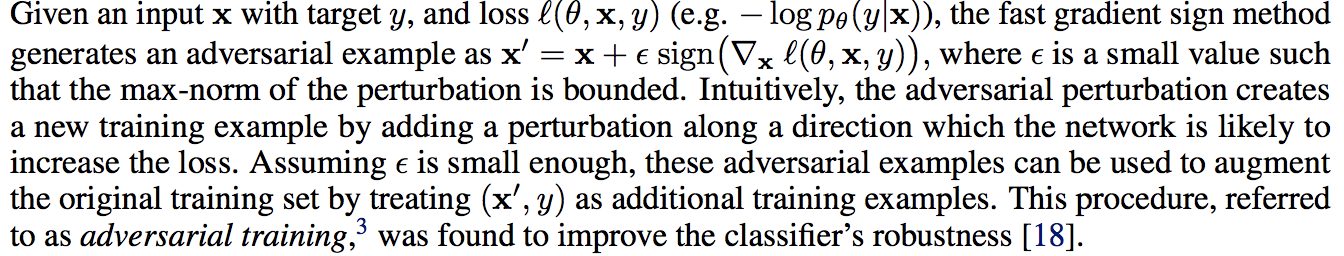

In [32]:
alpha = 0.5
clipping = 0.25
max_iter = 30000
K = 5  # ensemble size
eps = 1e-1

learning = {'mse': 0.00001,
             'nll': 0.1}
loss_dict = {'mse': torch.nn.MSELoss(),
             'nll': GaussianNLL()}

define_loss = 'nll'
ensemble = [GaussianRegressorNLL(x.size()[0], 100, y.size()[0],2) for i in range(K)]
learning_rate = learning[define_loss]
loss_function = loss_dict[define_loss]
optimizer = [optim.Adam(ensemble[i].parameters(),learning_rate) for i in range(K)]
losses =[loss_function for i in range(K)]

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Loss: 188598.296875
Loss at: 185979.90625


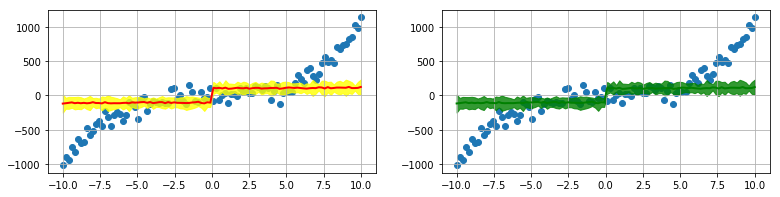

Loss: 81.68792724609375
Loss at: 81.36483001708984


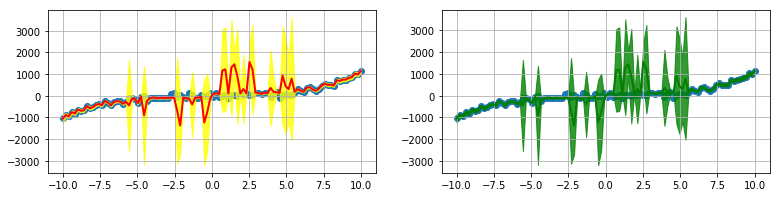

Loss: 75.98303985595703
Loss at: 75.38235473632812


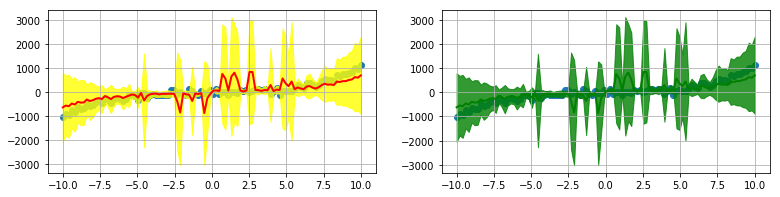

Loss: 1690.8099365234375
Loss at: 1690.8099365234375


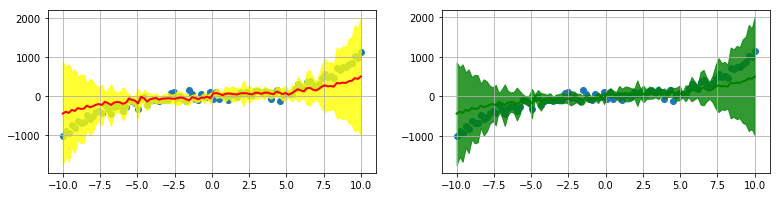

Loss: 564.4867553710938
Loss at: 564.4867553710938


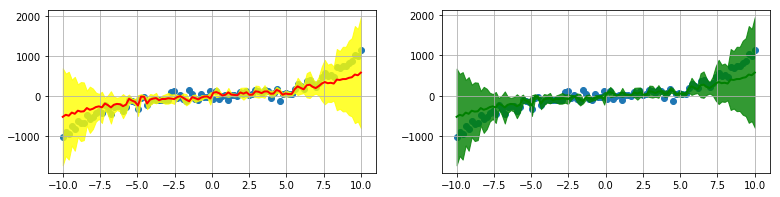

Loss: 179.06036376953125
Loss at: 179.06036376953125


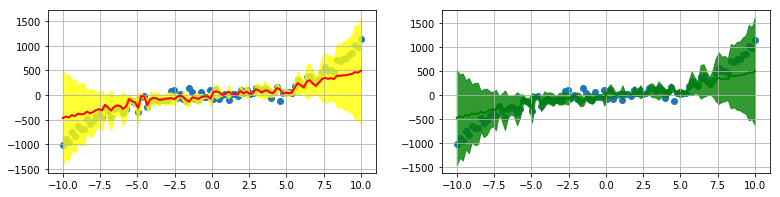

In [33]:
for i in range(max_iter):
    for model, opt, loss in zip(ensemble, optimizer, losses):
        inp = x.view(1,-1)
        if define_loss == 'nll':
            preds, var = model(Variable(inp, requires_grad=True))
            loss = loss_function(preds, var, y)
            preds.retain_grad()
            (alpha * loss).backward()
            
            ## Minimize the adversarial inputs
            x_prime = inp + (eps * torch.sign(preds.grad)).view(1,-1)
            preds_at, var_at = model(Variable(x_prime, requires_grad=True))
            loss_at = loss_function(preds_at, var_at, y)
            ((1-alpha) * loss_at).backward()
            
            ## Update optimizer
            opt.step()
            opt.zero_grad()
            
            #print("mean of adversarial input: {}".format(torch.mean(x_prime)))
            torch.nn.utils.clip_grad_norm(model.parameters(), clipping)
    
        elif define_loss == 'mse':
            preds, var = model(Variable(inp, requires_grad=True))
            loss = loss_function(preds, y)
            opt.step()
            opt.zero_grad()
            loss.backward()
            
    if i %5000 ==0:
        #print("Iter: {}, Loss: {}".format(i, loss.data.numpy()))
        print("Loss: {}".format(loss))
        print("Loss at: {}".format(loss_at))
        
        mean_en, var_en = mean_var_ensemble(ensemble, x)
        std = np.sqrt(var_en)
        upper_3 = mean_en + 3 * std
        lower_3 = mean_en - 3 * std
        #upper_6 = mean_en + 6 * std
        #lower_6 = mean_en - 6 * std
        #upper_9 = mean_en + 9 * std
        #lower_9 = mean_en - 9 * std
        
        mean_en_at, var_en_at = mean_var_ensemble(ensemble, x_prime)
        std_at = np.sqrt(var_en_at)
        upper_3_at = mean_en + 3 * std_at
        lower_3_at = mean_en - 3 * std_at
        
        plt.figure(1, figsize=(20,3))
        plt.subplot(131)
        plt.grid()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), mean_en.squeeze(), 'r-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_3.squeeze(), upper_3.squeeze(), color='yellow', alpha=0.8)
        
        plt.subplot(132)
        plt.grid()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), mean_en_at.squeeze(), 'g-', lw=2)
        plt.fill_between(x.data.numpy().squeeze(), lower_3_at.squeeze(), upper_3_at.squeeze(), color='green', alpha=0.8)
        
        
        #plt.scatter(x.data.numpy(), y.data.numpy())
        #plt.plot(x.data.numpy().squeeze(), mean_en.squeeze(), 'r-', lw=2)
        #plt.fill_between(x.data.numpy().squeeze(), lower_3.squeeze(), upper_3.squeeze(), color='darkblue', alpha=0.3)
        #plt.fill_between(x.data.numpy().squeeze(), lower_6.squeeze(), upper_6.squeeze(), color='mediumblue', alpha=0.5)
        #plt.fill_between(x.data.numpy().squeeze(), lower_9.squeeze(), upper_9.squeeze(), color='skyblue', alpha=0.7)

        plt.pause(0.1)
plt.ioff()
plt.show()